In [1]:
import pandas as pd

In [2]:
reviews = pd.read_csv("./scraped_reviews.csv", sep="\t")

In [3]:
len(reviews)

101650

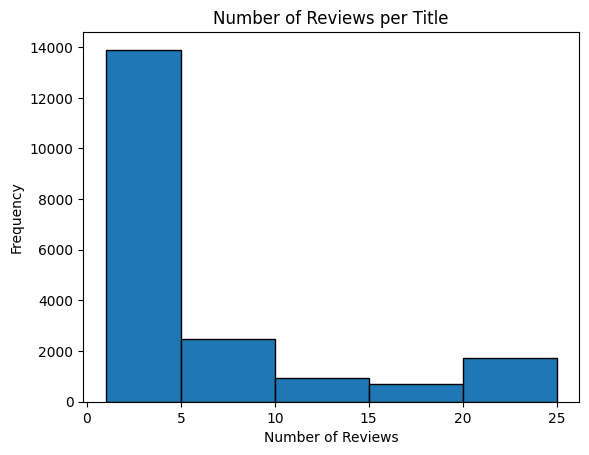

In [17]:
import matplotlib.pyplot as plt

counts = reviews['movie_id'].value_counts()

# Define bins for the histogram
bins = [1, 5, 10, 15, 20, 25]

# Create the histogram
plt.hist(counts, bins=bins, edgecolor='black')

# Set labels and title
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.title('Number of Reviews per Title')


plt.savefig('reviews_histogram.png')
# Show the plot
# plt.show()

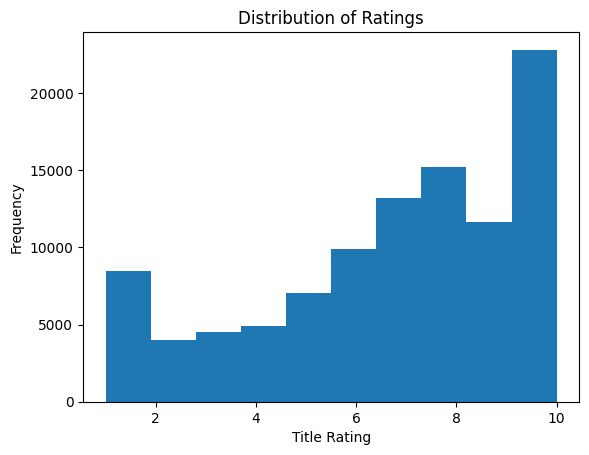

In [20]:
# reviews.hist()

# Plot the histogram of ratings
plt.hist(reviews['rating'])
plt.xlabel('Title Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')

plt.savefig('ratings_histogram.png')

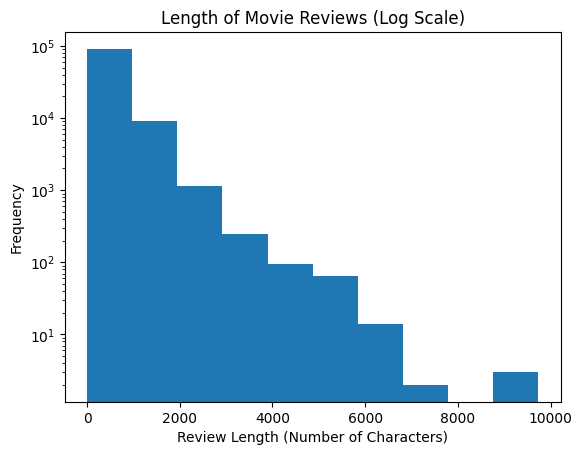

In [23]:
# Plot the histogram of rating lengths
# Use a log scale for Y
plt.hist(reviews['length'], log=True)
plt.xlabel('Review Length (Number of Characters)')
plt.ylabel('Frequency')
plt.title('Length of Movie Reviews (Log Scale)')

plt.savefig('length_histogram.png')

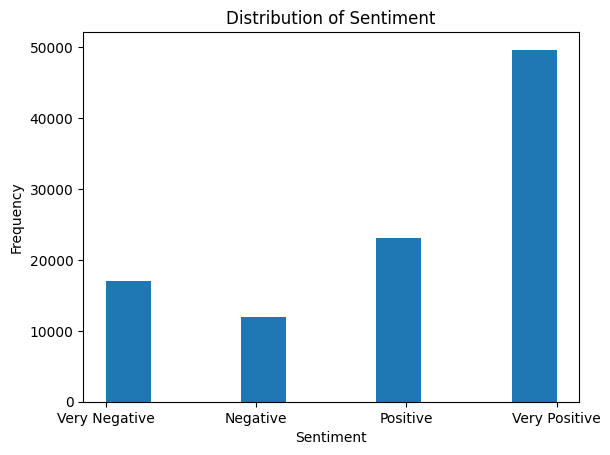

In [28]:
# Plot the sentiment histogram
plt.hist(reviews['sentiment'])
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment')
# X-axis: 0: Very Negative, 1: Negative, 2: Positive, 3: Very Positive
plt.xticks([0,1, 2, 3], ['Very Negative', 'Negative', 'Positive', 'Very Positive'])
plt.savefig('sentiment_histogram.png')

In [5]:
reviews["length"] = reviews["text"].apply(len)

In [6]:
# Divide ratings into 4 classes
# 1-3: negative
# 4-5: somewhat negative
# 6-7: somewhat positive
# 8-10: positive
def get_class(rating):
    if rating <= 3:
        return 0
        # return "Negative"
    elif rating <= 5:
        return 1
        # return "Somewhat Negative"
    elif rating <= 7:
        return 2
        # return "Somewhat Positive"
    else:
        return 3
        # return "Positive"
reviews["sentiment"] = reviews["rating"].apply(
    get_class
)

<AxesSubplot:>

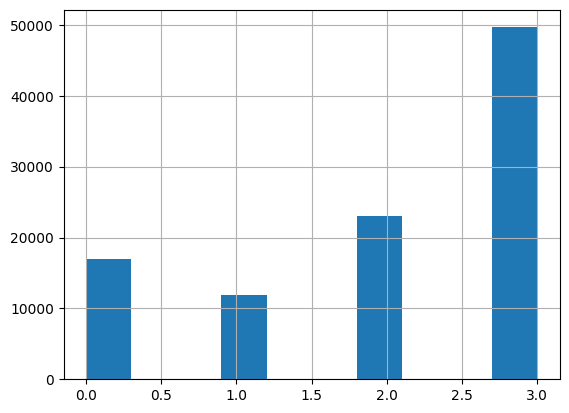

In [7]:
reviews["sentiment"].hist()

<AxesSubplot:xlabel='length', ylabel='sentiment'>

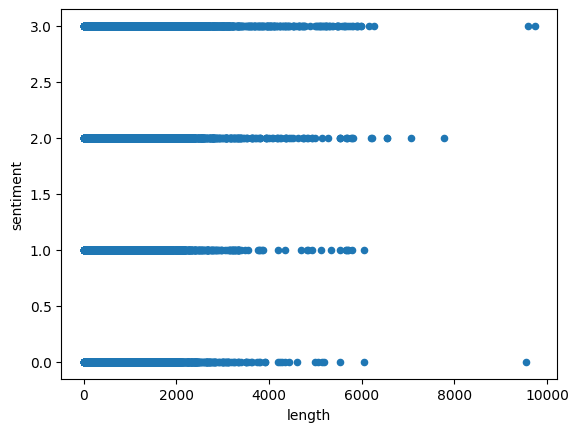

In [8]:
# Plot scatter plot of length of review vs. rating
reviews.plot.scatter(x="length", y="sentiment")

In [9]:
reviews["original_text"] = reviews["text"]

In [10]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

def clean(arr):
    wnlmt = WordNetLemmatizer()
    snbstm = SnowballStemmer("english")

    cleaned = []
    new_sentences = []
    for sentence in arr:    
        word_tokens = word_tokenize(sentence)
        for word in word_tokens:
            cleaned.append(snbstm.stem(wnlmt.lemmatize(word)))
        sentence = ' '.join(cleaned)
        new_sentences.append(sentence)
        cleaned = []

    df = pd.DataFrame(new_sentences, columns=["text"])

    return df["text"]


In [11]:
# import nltk
# nltk.download('wordnet')

In [12]:
reviews["text"] = clean(reviews["original_text"])

In [18]:
# Train a model to predict the rating of a review based on the review text
# First: Bag of words model
# Pipeline: first lower case, then remove punctuation, then remove stop words, then count words
from sklearn.feature_extraction.text import CountVectorizer

bow_transformer = CountVectorizer(analyzer="word", stop_words="english", max_features=2000).fit(reviews["text"])

# Transform the reviews into a sparse matrix
reviews_bow = bow_transformer.transform(reviews["text"])

In [19]:
reviews_bow

<33087x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 934292 stored elements in Compressed Sparse Row format>

In [20]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_bow, reviews["sentiment"], test_size=0.2, random_state=42)

In [21]:
# Cluster the reviews using KMeans into 4 clusters
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42).fit(X_train)

/home/shadi/miniconda3/envs/d4rl/envs/pt2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [22]:
# Predict the clusters for the test set
y_pred = kmeans.predict(X_test)

NameError: name 'y_test' is not defined

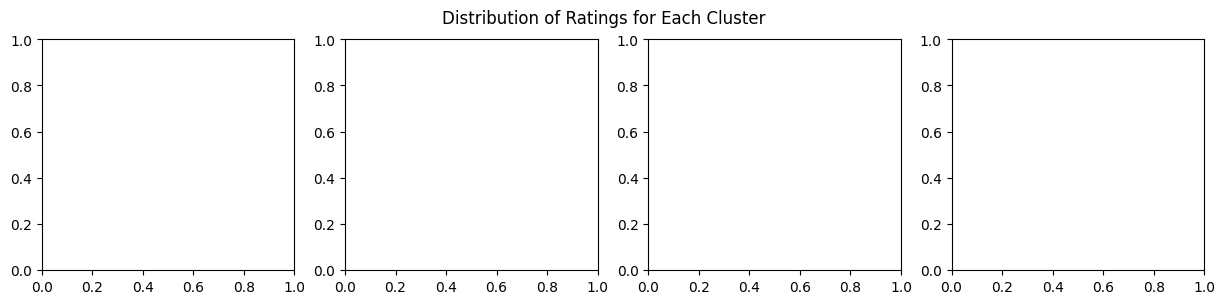

In [29]:
# For each cluster, plot the distribution of ratings
# 3x4 plot, each subplot is a histogram of ratings for a cluster
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(15, 3))

fig.suptitle('Distribution of Ratings for Each Cluster, Bag of Words Model')

for i in range(4):
    axs[i % 4].hist(y_test[y_pred == i])
    axs[i % 4].set_title(f"Cluster {i}")



In [24]:
# Instead of bow, use tfidf
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(reviews_bow)

reviews_tfidf = tfidf_transformer.transform(reviews_bow)

# Split the data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_tfidf, reviews["sentiment"], test_size=0.2, random_state=42)

In [25]:
# Use KMeans to cluster the reviews
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42).fit(X_train)

# Predict the clusters for the test set
y_pred = kmeans.predict(X_test)

/home/shadi/miniconda3/envs/d4rl/envs/pt2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


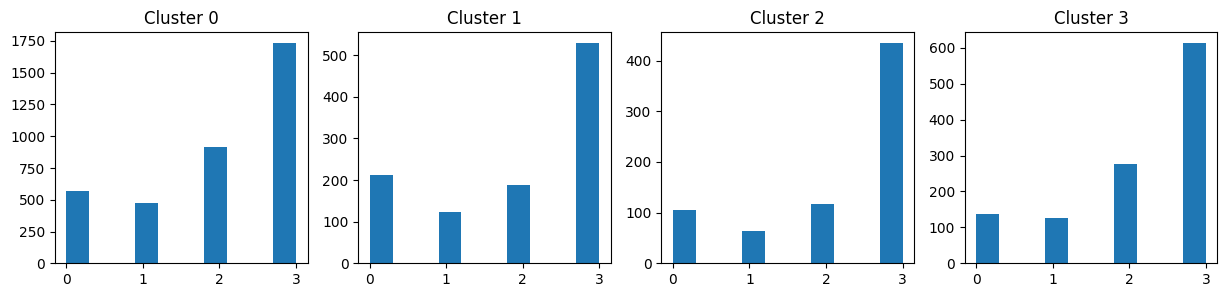

In [26]:
# For each cluster, plot the distribution of ratings
# 3x4 plot, each subplot is a histogram of ratings for a cluster
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(15, 3))

fig.suptitle('Distribution of Ratings for Each Cluster, TF-IDF Model')

for i in range(4):
    axs[i % 4].hist(y_test[y_pred == i])
    axs[i % 4].set_title(f"Cluster {i}")

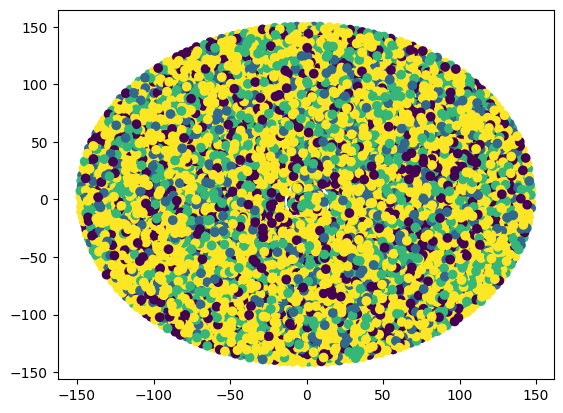

In [27]:
# Try to plot the reviews in 2D using tsne
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, init="random").fit_transform(X_train)

# Plot the reviews in 2D
import matplotlib.pyplot as plt

plt.title("Reviews in 2D Space using t-SNE")
plt.scatter(tsne[:, 0], tsne[:, 1], c=y_train)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(reviews_bow, reviews["sentiment"], test_size=0.2, random_state=42)

In [40]:
# Extra tree classifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report

trclf = ExtraTreesClassifier()

trclf.fit(X_train, y_train)

# Predict the clusters for the test set
y_pred = trclf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.46      0.50      1026
           1       0.14      0.01      0.01       791
           2       0.39      0.18      0.25      1495
           3       0.59      0.90      0.71      3306

    accuracy                           0.56      6618
   macro avg       0.42      0.39      0.37      6618
weighted avg       0.48      0.56      0.49      6618



In [ ]:
# Plot the confusion matrix to conf_matrix_treeclf.png
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(trclf, X_test, y_test, cmap=plt.cm.Blues)
plt.savefig('conf_matrix_treeclf.png')

In [37]:
bow_transformer.get_feature_names_out()

array(['000', '10', '100', ..., 'youtub', 'zero', 'zombi'], dtype=object)

In [44]:
word_map = {"wast": "waste", "movi":"movie", "wa": "want"}

In [48]:
word_scores = bow_transformer.get_feature_names_out()

feature_names = trclf.feature_importances_

all_features = [(k,v) for k, v in zip(word_scores, feature_names)]

all_features.sort(key=lambda x: x[1], reverse=True)

for feature in all_features[:10]:
    
    print("Word: {}, Score: {:.3f}".format(word_map.get(feature[0], feature[0]), feature[1]))

Word: waste, Score: 0.006
Word: worst, Score: 0.006
Word: bad, Score: 0.005
Word: want, Score: 0.005
Word: great, Score: 0.005
Word: love, Score: 0.005
Word: movie, Score: 0.004
Word: film, Score: 0.004
Word: like, Score: 0.004
Word: good, Score: 0.004


In [55]:
# Train small deberta model to predict the rating of a review based on the review text
# Plot the tsne of the embeddings
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
import evaluate
import numpy as np

model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-xsmall", num_labels=4)

# Freeze the weights of the model
# for param in model.base_model.parameters():
#     param.requires_grad = False

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-xsmall")

# Use huggingface dataset format
reviews_hf = Dataset.from_pandas(reviews)
reviews_hf = reviews_hf.remove_columns(["title", "rating", "movie_id", "length", "text"])
reviews_hf = reviews_hf.rename_columns({"sentiment":"label", "original_text":"text"})

reviews_hf = reviews_hf.train_test_split(test_size=0.2, seed=42)

# Use huggingface trainer to train the model
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=128)

reviews_hf = reviews_hf.map(preprocess_function, batched=True)

train_dataset, test_dataset = reviews_hf["train"], reviews_hf["test"]

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'pooler.dense.bias', 'classifier.weight', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/shadi/miniconda3/envs/d4rl/envs/pt2/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:470: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
S

Map:   0%|          | 0/26469 [00:00<?, ? examples/s]

Map:   0%|          | 0/6618 [00:00<?, ? examples/s]

In [56]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [57]:
train_dataset

Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 26469
})

In [52]:
reviews_hf

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 26469
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6618
    })
})

In [21]:
train_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 9290
})

In [58]:
trainer.train()

/home/shadi/miniconda3/envs/d4rl/envs/pt2/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/6620 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 1.3884, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'loss': 1.3865, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'loss': 1.3778, 'learning_rate': 3e-06, 'epoch': 0.02}
{'loss': 1.3798, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}
{'loss': 1.3667, 'learning_rate': 5e-06, 'epoch': 0.03}
{'loss': 1.3454, 'learning_rate': 6e-06, 'epoch': 0.04}
{'loss': 1.3346, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.04}
{'loss': 1.2932, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.05}
{'loss': 1.2354, 'learning_rate': 9e-06, 'epoch': 0.05}
{'loss': 1.2476, 'learning_rate': 1e-05, 'epoch': 0.06}
{'loss': 1.2169, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.07}
{'loss': 1.1415, 'learning_rate': 1.2e-05, 'epoch': 0.07}
{'loss': 1.2256, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.08}
{'loss': 1.2624, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.08}
{'loss': 1.2168, 'learning_rate': 1.5e-05, 'epoch': 0.09}
{'loss': 1.221, 'learni

TrainOutput(global_step=6620, training_loss=0.7390676607178057, metrics={'train_runtime': 461.7636, 'train_samples_per_second': 229.286, 'train_steps_per_second': 14.336, 'train_loss': 0.7390676607178057, 'epoch': 4.0})

In [59]:
trainer.evaluate()

  0%|          | 0/104 [00:00<?, ?it/s]

{'eval_loss': 0.9937605261802673,
 'eval_accuracy': 0.6498942278634029,
 'eval_runtime': 6.7165,
 'eval_samples_per_second': 985.333,
 'eval_steps_per_second': 15.484,
 'epoch': 4.0}

In [60]:
# Classify the test set using the trained model
predictions = trainer.predict(test_dataset)

  0%|          | 0/104 [00:00<?, ?it/s]

In [78]:
y_pred = predictions.predictions.argmax(axis=1)

In [71]:
y_labels_hf = test_dataset["label"]

In [79]:
print(classification_report(y_labels_hf, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.64      0.66      1064
           1       0.39      0.29      0.33       760
           2       0.46      0.47      0.47      1530
           3       0.77      0.82      0.79      3264

    accuracy                           0.65      6618
   macro avg       0.57      0.56      0.56      6618
weighted avg       0.64      0.65      0.64      6618



: 

In [ ]:
# Confusioon matrix  
plot_confusion_matrix(trclf, X_test, y_test, cmap=plt.cm.Blues)

plt.savefig('conf_matrix_deberta.png')
